In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

ImportError: ignored

In [2]:
# どうも書籍の上記手法は鯖落ちによってうごかないみたいなので、以下のIssueによるものを利用
# https://github.com/YutaroOgawa/Deep-Reinforcement-Learning-Book/issues/4
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)
# mnist

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

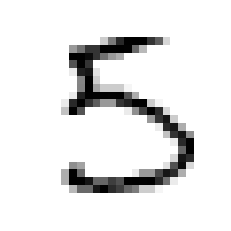

'5'

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[60015]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
y[60015]

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
# 予測させてみる
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# マニュアルで交差検証を行う, KFoldと違いStratifiedKFoldは学習データが一定になるように抽出してくれるらしい
# ところでこの例では20%をテストにまわしているが、この20%はどういう根拠で出てきた数値なんだろうか

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds, y_train_folds = X_train[train_index], y_train_5[train_index]
  X_test_fold, y_test_fold = X_train[test_index], y_train_5[test_index]
  
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96745
0.96715
0.96445


In [10]:
# 交差検証によるaccuracyを計測, 今回は歪んだデータセットなのでaccuracyは不適
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96745, 0.96715, 0.96445])

In [11]:
# 各foldに対するaccを計測、交差検証ではない
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ...,  True, False, False])

In [12]:
# 混同行列
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53798,   781],
       [ 1238,  4183]])

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # precision(適合率) = 真陽性/(真陽性+偽陽性), 陽性のうちの真陽性率
print(recall_score(y_train_5, y_train_pred)) # recall(再現率) = 真陽性/(真陽性+偽陰性), 陽性をどれぐらいの確率で検知できるか

0.8426672038678485
0.7716288507655414


In [14]:
# precisionとrecallで調和平均をとったもの
# 調和平均以外にも幾何平均なども良いのではないか　
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8055849783341358

In [15]:
# precisionを上げる(誤検知を減らす)をしてみる
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threathold = 0
y_some_digit_pred = (y_scores > threathold)
print(y_some_digit_pred)

threathold = 20000
y_some_digit_pred = (y_scores > threathold)
print(y_some_digit_pred)

[648.30712337]
[ True]
[False]


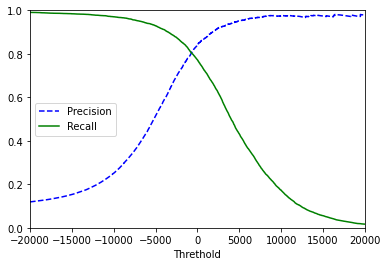

In [16]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thretholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threthold(precisions, recalls, thretholds):
  plt.plot(thretholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thretholds, recalls[:-1], 'g-', label='Recall')
  plt.xlabel('Threthold')
  plt.legend(loc='center left')
  plt.ylim([0, 1])
  plt.xlim([-20000, 20000]) # 見づらかったので追加, あんまりよくない

plot_precision_recall_vs_threthold(precisions, recalls, thretholds)
plt.show()

In [17]:
# 上記のprecision vs recallグラフからprecisionが90%になる点を選んでしきい値を調整
y_train_pred_90 = (y_scores > 2000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9051393505497315
0.6530160486995019


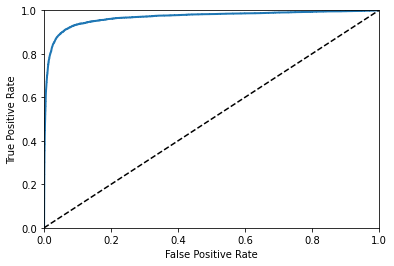

In [18]:
# ROC(TP, FPの比)のグラフ、おそらく裏でThrethouldがいい感じに仕事してる
from sklearn.metrics import roc_curve
fpr, tpr, thretholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

In [19]:
# AUC(ROC曲線の面積), 1が理想
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9679313937786345

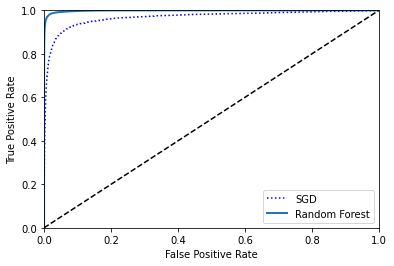

In [20]:
# AUCでSGDClassifierとRandomForestClassifierの性能を比較
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thretholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [21]:
# RandomForestのAUC
roc_auc_score(y_train_5, y_scores_forest)

0.9984305854936785

In [22]:
# 多クラス分類をしてみる, 内部ではOVA法が使われている
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)

['5']
[[-15687.31845834 -28048.38596643  -7815.25312808  -2212.45476937
  -11192.24270228   2689.59879891 -10466.16872709 -23416.8177143
   -2876.03304782 -19540.29897325]]
5
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [23]:
# OVO法で多クラス分類をしてみる
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

['5']
45


In [24]:
# 入力をスケーリングすることで精度の向上を試みる
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.9022 , 0.89635, 0.90475])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[[5590    0   16    9    9   42   32    4  220    1]
 [   0 6421   41   24    3   45    6    7  181   14]
 [  24   30 5262   92   74   28   61   36  343    8]
 [  29   20  112 5251    1  198   23   45  394   58]
 [  12   13   40   10 5233    7   32   19  321  155]
 [  24   17   25  153   48 4480   82   13  508   71]
 [  29   18   45    2   41   86 5565    4  128    0]
 [  19   13   47   24   51   10    4 5705  177  215]
 [  13   61   38   94    1  121   33    6 5439   45]
 [  22   23   25   59  124   32    1  179  364 5120]]


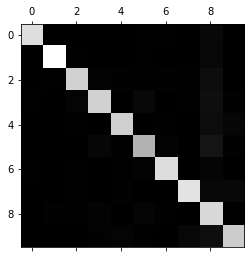

In [25]:
# confusion matrixを使って精度を可視化してみる
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

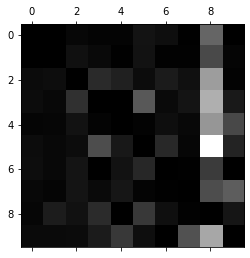

In [26]:
# confusion matrixを行ごとに正規化して、対角線を無視するようにしてみる
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [33]:
# 多ラベル分類を試みる
from sklearn.neighbors import KNeighborsClassifier

# y_train_large = (y_train >= 7)
# y_train_odd = (y_train % 2 == 1)
y_train_not7 = (y_train != '7')
y_train_not2 = (y_train != '2')
y_multilabel = np.c_[y_train_not7, y_train_not2]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [34]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [35]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9965913658282984

In [36]:
# ノイズが含まれた画像(MNIST)のノイズ除去をしてみる
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

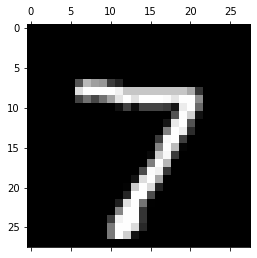

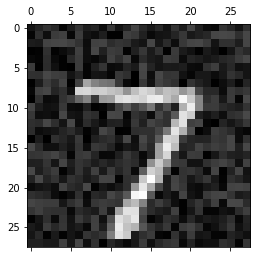

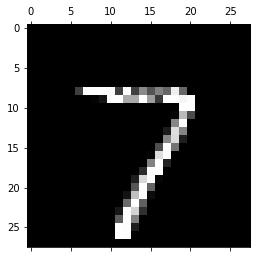

In [50]:
knn_clf.fit(X_train_mod, y_train_mod) 
some_index = 0
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.matshow(X_test[some_index].reshape(28, 28), cmap=plt.cm.gray)
plt.matshow(X_test_mod[some_index].reshape(28, 28), cmap=plt.cm.gray)
plt.matshow(clean_digit.reshape(28, 28), cmap=plt.cm.gray)
plt.show()